# From kernel string to structure drawing

### Task & Goal


### Steps
EXTRACT INFORMATION FROM STRING  
DETERMINE STRUCTURE  
DRAW SHAPES  

In [1]:
import numpy as np
import re
import networkx as nx
from matplotlib import pyplot as plt

#### What is an invalid string?

Invalid characters  
Angle: [-179, 180]  
etc.

In [2]:
#error handling step 1
def check_string_valid(string):
    if re.search("[$ß€]", string): #all special characters?
        raise Exception("bad string")
        
#check_string_valid("@90 a ß90 b")

## EXTRACT INFORMATION FROM STRING

First, count domains and create a table that has nrow corresponding to dom. count. As the string is very systematic, with a regional expression I can separate the domains with all their information given.  
The good thing here is that the sequence of domains is clear from the string.  
Most important is to know which domain is paired with which. As a human, when I find a bracket in the string, I look for its counterpart. This will have to be done in the second step and put the pairing info into a dictionary(?).

In [7]:
#table(int) - cols: angle before dom, length, dom type?, if there is a strand break after  
#dictionary - pairedness  
#list of list - name of domains, their preliminary type 

def comprehend_string(string):
    #separate domains/count
    pattern = re.compile('@?-?[0-9]* ?[a-z|A-Z|0-9|\*]+[ \(]? ?\+?|\) ?\+?')
    dom_raw_list = pattern.findall(string)
    dom_count = len(dom_raw_list)
        
    #create empty data structures     
    struct_info_array = np.zeros((dom_count, 4), dtype = 'int') #3 cols rn, sb not needed here
    name_list1 = []
    
    #loop through the raw domains, extract  
    for dom_i in range(len(dom_raw_list)):
        dom = dom_raw_list[dom_i]
        dom = dom.strip()
        
        #fill table
        if re.search("\s", dom):
            dom_parts = re.split("\s", dom)
            
            for segm in dom_parts:
                if segm[0] is "@": #col0 angle
                    segm = segm.lstrip("@")
                    struct_info_array[dom_i, 0] = int(segm) #col0 to write to
                    struct_info_array[dom_i, 1] = np.sign(int(segm)) #col1 to write to
                    
                elif segm is "+": #col2 strand break
                    struct_info_array[dom_i, 2] = 1         #col2 to write to
                else:
                    name_list1.append(segm) #only keep the name part further
        else:
            name_list1.append(dom)
        
    #pairedness dictionary
    paired_dict = {}
    
    for dom_i2 in range(len(dom_raw_list)):
        if re.search("\(", dom_raw_list[dom_i2]):
            bracket_count = 1
            for next_dom in range(dom_i2+1, len(dom_raw_list)):
                if re.search("\(", dom_raw_list[next_dom]):
                    bracket_count += 1
                elif re.search("\)", dom_raw_list[next_dom]):
                    bracket_count -= 1
                if bracket_count == 0:
                    paired_dict[dom_i2] = next_dom
                    break
    
    #name list of list / finding hairpin loops
    #paireds in dict, hairpin loop known, other are unpaired -> substructure from these?
    name_final_lol = []
    
    for dom_i3 in range(len(name_list1)):
        
        #paireds
        if re.search("\(", name_list1[dom_i3]):
            typ = "paired"
            name = name_list1[dom_i3].strip("(+ ")
        
        #correcting closing bracket name
        elif re.search("\)", name_list1[dom_i3]):
            typ = "paired"
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_i3)]
            if re.search("\*", name_list1[index_of_pair]):
                name = name_list1[index_of_pair].strip("\(").strip("\*")
            else:
                name = name_list1[index_of_pair].strip("\(") + "*"
        
        #all other are unpaireds
        else:
            typ = "unpaired"
            name = name_list1[dom_i3].strip("+ ")
        
        name_final_lol.append([name, typ])
        
    return dom_raw_list, struct_info_array, paired_dict, name_final_lol

In [8]:
string = "@-45 d1S T2 @-135 b( a( t2( + ) ) c*( t1* + ) )"
comprehend_string(string)[1:4]

(array([[ -45,   -1,    0,    0],
        [   0,    0,    0,    0],
        [-135,   -1,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    1,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    1,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]]),
 {2: 10, 3: 6, 4: 5, 7: 9},
 [['d1S', 'unpaired'],
  ['T2', 'unpaired'],
  ['b', 'paired'],
  ['a', 'paired'],
  ['t2', 'paired'],
  ['t2*', 'paired'],
  ['a*', 'paired'],
  ['c*', 'paired'],
  ['t1*', 'unpaired'],
  ['c', 'paired'],
  ['b*', 'paired']])

In [118]:
string2 = "t1( c( a( + t2* ) b*( d2 t3 + ) ) )"
comprehend_string(string2)[1:4]

(array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]),
 {0: 10, 1: 9, 2: 4, 5: 8},
 [['t1', 'paired'],
  ['c', 'paired'],
  ['a', 'paired'],
  ['t2*', 'unpaired'],
  ['a*', 'paired'],
  ['b*', 'paired'],
  ['d2', 'unpaired'],
  ['t3', 'unpaired'],
  ['b', 'paired'],
  ['c*', 'paired'],
  ['t1*', 'paired']])

In [17]:
string3 = "@-90 aa( @-135 i1 @-90 da( dl ) @-135 i2 @-90 aca( acl ) @-135 vr @-135 pa( pl ) @-135 i3 ) @0 c"
comprehend_string(string3)[1:4]

(array([[ -90,   -1,    0,    0],
        [-135,   -1,    0,    0],
        [ -90,   -1,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [-135,   -1,    0,    0],
        [ -90,   -1,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [-135,   -1,    0,    0],
        [-135,   -1,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [-135,   -1,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]]),
 {0: 14, 2: 4, 6: 8, 10: 12},
 [['aa', 'paired'],
  ['i1', 'unpaired'],
  ['da', 'paired'],
  ['dl', 'unpaired'],
  ['da*', 'paired'],
  ['i2', 'unpaired'],
  ['aca', 'paired'],
  ['acl', 'unpaired'],
  ['aca*', 'paired'],
  ['vr', 'unpaired'],
  ['pa', 'paired'],
  ['pl', 'unpaired'],
  ['pa*', 'paired'],
  ['i3', 'unpaired'],
  ['aa*', 'paired'],
  ['c', 'unpaired']])

## DETERMINE STRUCTURE 

### 1a. Create domain node graph
Figure out if an unpaired region is from a special type - by making a network graph of the connected domains (either connected by sequence (red edge) or by pairedness (green edge)) we can find subgraphs that correspond to special domain structures that need to be handled differently.  

In [9]:
def create_skeleton(dom_raw_list, paired_dict, name_final_lol):
    #append edges to graph
    G = nx.Graph()
    
    for dom_to_dom in range(len(name_final_lol)-1):
        if re.search("\+", dom_raw_list[dom_to_dom]) is None:
            G.add_edge(dom_to_dom, dom_to_dom+1, color='r') #domains that have a connection point are conn. with red edge
    for pair in paired_dict:
        G.add_edge(pair, paired_dict[pair], color='g') #paired domains are connected with green edge
    
    return G

In [10]:
def draw_skeleton(G):
    pos = nx.kamada_kawai_layout(G)
    colors = [G[u][v]['color'] for u,v in G.edges()]
    plt.figure(figsize=(16,9))

    nx.draw_networkx(G, pos = pos, with_label = True, node_size=600,font_size=15, edge_color=colors, 
                     node_color='y', width=2)

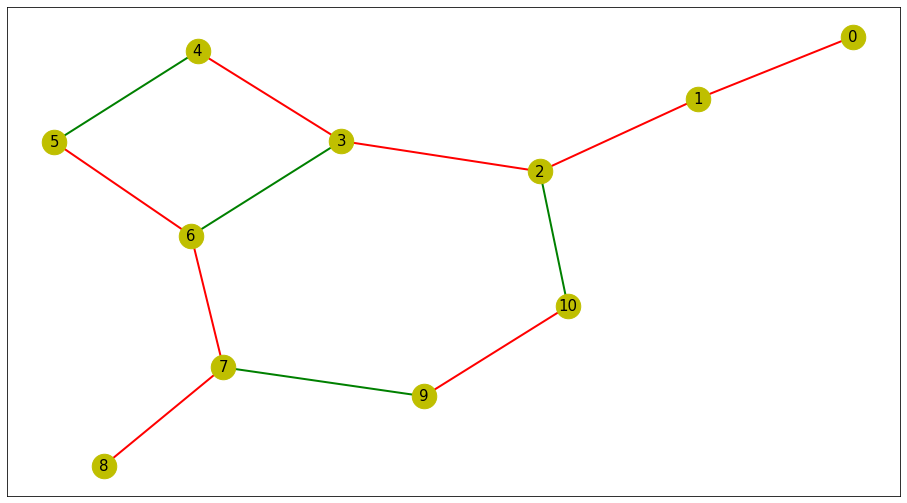

In [11]:
string = "@-45 d1S T2 @-135 b( a( t2( + ) ) c*( t1* + ) )"

dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)

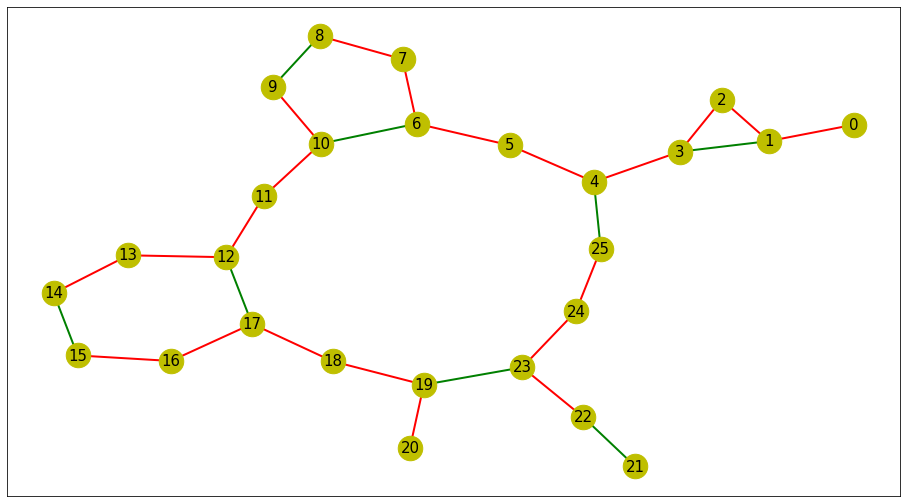

In [9]:
string = "a b( c ) d( e f( g h( + ) ) i j( k l( + ) m ) n o( p + q( + ) ) r )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)

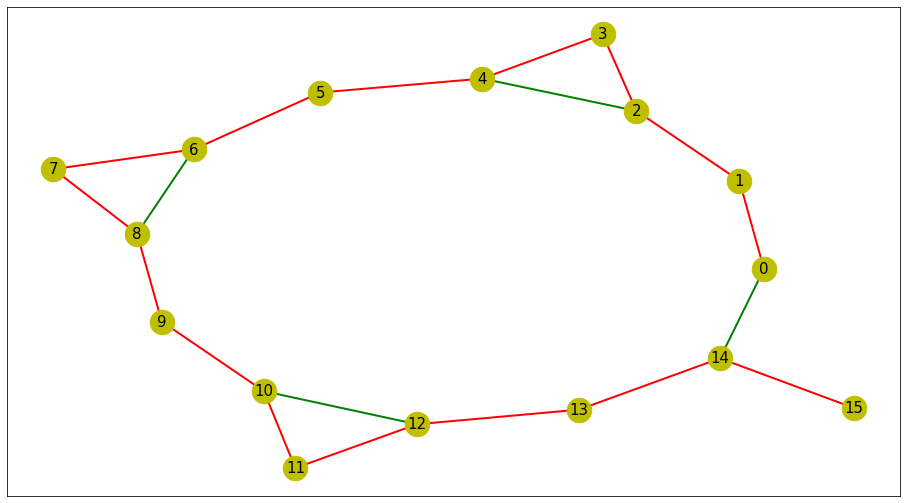

In [5]:
string = "@-90 aa( @-135 i1 @-90 da( dl ) @-135 i2 @-90 aca( acl ) @-135 vr @-135 pa( pl ) @-135 i3 ) @0 c"

dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)

### 1b. Determining unpaired domain types
Currently we check:   
hairpin loop: easy, its neighbors are paired  
unhinged: has only one neighbor domain - these will need extra care, especially ones resulting from strand break  
bulgeloop: cycles with odd nodes and only 1! unpaired dom always has the strictly taken 'bulge'  
multiloop: hard, as any number of unpaired doms can be connected with each other, only check r-g-r connection  
crossroad: if a cycle is larger or equal to 6 nodes and has no unpaired domains, it is a crossroad

nick - not tracked, but strand breaks will need much work in general

In [12]:
def ds1_find_type_of_unpaired_v2(G, paired_dict, name_final_lol):
    #index of ununpaireds - these don't need to be checked
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
    
    #get unpaired too
    unpaired_node_list = []
    for node_index in range(len(name_final_lol)):
        if node_index not in paired_node_list:
            unpaired_node_list.append(node_index)
    
    #cycles of the skeleton graph
    cycle_list_G = nx.cycle_basis(G) #neat!
    multiloop_list = []
    crossroad_list = []
    
    #look through cycles, where 3cycles are hairpin, 5c. are bulge and longer ones nest multiloops
    for cycle in cycle_list_G:
        if len(cycle) == 3: #always hairpin
            for item in cycle:
                if item in unpaired_node_list:
                    name_final_lol[item][1] = "hairpin loop" #name altering
                    unpaired_node_list.remove(item) #trim unpaired list from known items
        elif len(cycle) > 3 & len(cycle) % 2 == 1: #current bulge def
            unpaired_here = []
            for item in cycle:
                if item in unpaired_node_list:
                    unpaired_here.append(item)
            if len(unpaired_here) == 1:
                name_final_lol[unpaired_here[0]][1] = "bulgeloop" #name altering
                unpaired_node_list.remove(unpaired_here[0]) #trim unpaired list from known items
         
        #find multiloops, the corresponding domains are their own list item in multiloop_list
        crossroad_tracker = True
        
        if len(cycle) >= 6:
            curr_multiloop = []
            for index in range(len(cycle)):
                if cycle[index] in unpaired_node_list:
                    crossroad_tracker = False
                    
                    if cycle[index-3] in unpaired_node_list :
                        connections = [n for n in G.edges.data(nbunch=cycle[index-1])]
                        for edge in connections:
                            #only need to check paired edge between these2
                            if edge[1] == cycle[index-2] and edge[2]['color'] is 'g': 
                                name_final_lol[cycle[index-3]][1] = "multiloop"
                                name_final_lol[cycle[index]][1] = "multiloop" #altering names
                                if cycle[index] not in curr_multiloop:
                                    curr_multiloop.append(cycle[index])
                                if cycle[index-3] not in curr_multiloop:
                                    curr_multiloop.append(cycle[index-3])
            if len(curr_multiloop) > 0:
                multiloop_list.append(curr_multiloop)
                for dom in curr_multiloop:
                    unpaired_node_list.remove(dom) #trim unpaired list from known items
            if crossroad_tracker is True: #if no unpaired region in cycle, it is a crossroad
                crossroad_list.append(cycle)
    
    #unhinged sequence
    for node_index in unpaired_node_list:
        #first neighbors
        direct_neigh = [n for n in G.neighbors(node_index)] #neighbors of current node
        
        #start from unhinged and go until all neighbors are unpaired
        if len(direct_neigh) == 1:
            name_final_lol[node_index][1] = "unhinged"
            
            next_neigh = direct_neigh
            before = [node_index]
            while len(next_neigh) == 1 and next_neigh[0] in unpaired_node_list:
                name_final_lol[next_neigh[0]][1] = "unhinged sequence"
                before.append(next_neigh[0])
                next_neigh = [n for n in G.neighbors(next_neigh[0])]
                next_neigh.remove(before[-2])
            for step in before:
                unpaired_node_list.remove(step) #bug with this line, cuts out 20 below, could implement it a bit diff
    
    #remaining is unknown but probably linear
    for remain in unpaired_node_list:
        name_final_lol[remain][1] = "ambiguous"
    
    return name_final_lol, multiloop_list, crossroad_list, cycle_list_G

In [13]:
string = "a b( c d e f ) g h i j"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
#draw_skeleton(skeleton_graph)
ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)

([['a', 'unhinged'],
  ['b', 'paired'],
  ['c', 'multiloop'],
  ['d', 'ambiguous'],
  ['e', 'ambiguous'],
  ['f', 'multiloop'],
  ['b*', 'paired'],
  ['g', 'unhinged sequence'],
  ['h', 'unhinged sequence'],
  ['i', 'unhinged sequence'],
  ['j', 'unhinged']],
 [[2, 5]],
 [],
 [[2, 3, 4, 5, 6, 1]])

In [8]:
string = "a b( c ) d( e f( g h( + ) ) i j( k l( + ) m ) n o( p + q( + ) ) r )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)

([['a', 'unhinged'],
  ['b', 'paired'],
  ['c', 'hairpin loop'],
  ['b*', 'paired'],
  ['d', 'paired'],
  ['e', 'multiloop'],
  ['f', 'paired'],
  ['g', 'bulgeloop'],
  ['h', 'paired'],
  ['h*', 'paired'],
  ['f*', 'paired'],
  ['i', 'multiloop'],
  ['j', 'paired'],
  ['k', 'multiloop'],
  ['l', 'paired'],
  ['l*', 'paired'],
  ['m', 'multiloop'],
  ['j*', 'paired'],
  ['n', 'multiloop'],
  ['o', 'paired'],
  ['p', 'ambiguous'],
  ['q', 'paired'],
  ['q*', 'paired'],
  ['o*', 'paired'],
  ['r', 'multiloop'],
  ['d*', 'paired']],
 [[16, 13], [5, 24, 11, 18]],
 [[2, 3, 1],
  [16, 15, 14, 13, 12, 17],
  [5, 6, 10, 11, 12, 17, 18, 19, 23, 24, 25, 4],
  [9, 8, 7, 6, 10]])

In [12]:
string = "a( b c( d( e ) f( + )) g ) h i"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)

([['a', 'paired'],
  ['b', 'multiloop'],
  ['c', 'paired'],
  ['d', 'paired'],
  ['e', 'hairpin loop'],
  ['d*', 'paired'],
  ['f', 'paired'],
  ['f*', 'paired'],
  ['c*', 'paired'],
  ['g', 'multiloop'],
  ['a*', 'paired'],
  ['h', 'unhinged sequence'],
  ['i', 'unhinged']],
 [[1, 9]],
 [[7, 6, 5, 3, 2, 8]],
 [[1, 2, 8, 9, 10, 0], [4, 5, 3], [7, 6, 5, 3, 2, 8]])

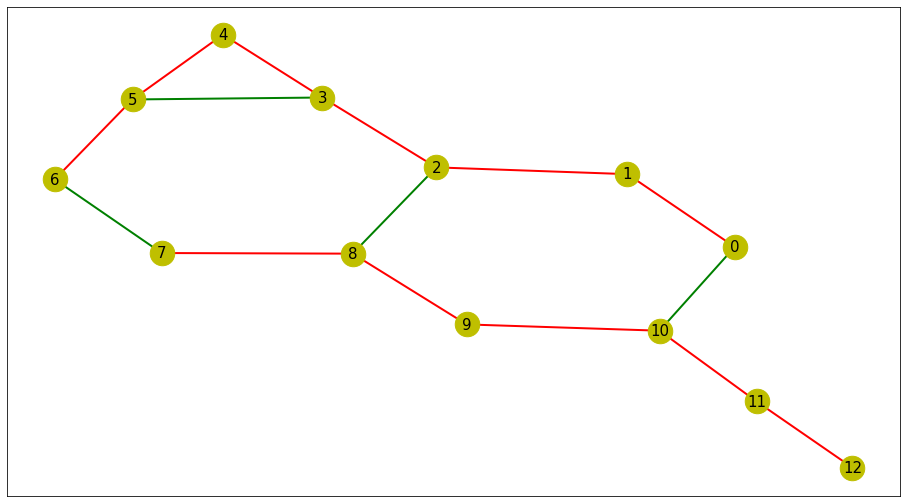

In [13]:
draw_skeleton(skeleton_graph)

### 2. Angle completion
Given angles determine the side for the substructure they are in. Using this, the whole column can be filled around the given info, if not provided, default is negative (-1) side.

In [14]:
def ds2_fill_side_col(struct_info_array, cycle_list_G):
    dom_count = len(struct_info_array[:,1])
    
    #first loop through cycles
    for cycle in cycle_list_G:
        sides_there = []
        for dom_cyc in cycle:
            sides_there.append(struct_info_array[dom_cyc, 1])
            
        if 1 in sides_there and -1 in sides_there:
            raise ValueError(f'conflicting angles with domains of index: {cycle}')   #not how should be handled
        #pos substruc
        if 1 in sides_there:
            for dom_cyc in cycle:
                struct_info_array[dom_cyc, 1] = 1
        #neg substruc or all 0
        else:
            for dom_cyc in cycle:
                struct_info_array[dom_cyc, 1] = -1
    
    #then remaining ones are just based on previous neighbor to look more homogenous
    for dom_index in range(dom_count):
        if struct_info_array[dom_index, 1] == 0: #don't change if already given side
                if dom_index == 0:
                    struct_info_array[0, 1] = -1
                else:
                    struct_info_array[dom_index, 1] = struct_info_array[dom_index-1, 1]
        
    return struct_info_array

In [18]:
string = "a b( c ) d( e f( g h( + ) ) i j( k l( + ) m ) n o( p + q( + ) ) r )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
ds2_fill_side_col(struct_info_array, cycle_list_G)

array([[ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  1,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  1,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  1,  0],
       [ 0, -1,  1,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  0]])

In [17]:
string = "@-90 a( b ) @-90 c @90 d( e ) @90 f"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
ds2_fill_side_col(struct_info_array, cycle_list_G)

array([[-90,  -1,   0,   0],
       [  0,  -1,   0,   0],
       [  0,  -1,   0,   0],
       [-90,  -1,   0,   0],
       [ 90,   1,   0,   0],
       [  0,   1,   0,   0],
       [  0,   1,   0,   0],
       [ 90,   1,   0,   0]])

In [19]:
string = "a b( @-45 c d e @45 f ) g h i j"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
ds2_fill_side_col(struct_info_array, cycle_list_G)

ValueError: conflicting angles with domains of index: [2, 3, 4, 5, 6, 1]

### 3. Determine traversing order based on graph 

Start at the beginning, walk along the network with the following preferences:  
-If it is a paired domain, we draw its pair too (since its obvious and it gives another constraint for the structure)  
-Check if domain is in cycle(substructure), if yes, we prioritize the cycle elements and get from in-point to out-point  
-While walking along the cycle, put the neighbors not in the current cycle to the back

In [20]:
#determine order of traversal (order of domains to build up)

def ds3a_determine_contstruct_order(skeleton_graph, paired_dict):
    cycle_list_G = nx.cycle_basis(skeleton_graph)
    
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
    
    def find_cycle_where_index_belongs(dom_index, cycle_list_G): #now finds largest cycle
        found = []
        for cycle in cycle_list_G:
            if dom_index in cycle and len(cycle) > len(found):
                found = cycle
        return found
    
    def resort_list_to_start_by_spec_value(dom_index, list_with_value):
        index = list_with_value.index(dom_index)
        sorted_list = []
        for i in range(len(list_with_value)):
            sorted_list.append(list_with_value[index-len(list_with_value)+i])
        return sorted_list
    
    def give_pair_of_domain(dom_index, paired_dict):
        if dom_index in paired_dict:
            return paired_dict[dom_index]
        elif dom_index in list(paired_dict.values()):
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_index)]
            return index_of_pair
        else:
            raise ValueError('not actually paired')
    
    #
    traverse_order = [0]
    
    for node in traverse_order:
        current_in_travord = traverse_order.index(node)
        counter = 0 #helps with insert index
        
        #pair primary
        if node in paired_node_list:
            pair_first = give_pair_of_domain(node, paired_dict) #pair first!
            if pair_first not in traverse_order:
                traverse_order.insert(current_in_travord+1, pair_first)
                counter += 1
        
        #cycle secondary
        its_cycle = find_cycle_where_index_belongs(node, cycle_list_G)
        if len(its_cycle) != 0: #if in cycle
            resorted_cycle = resort_list_to_start_by_spec_value(node, its_cycle)
            
            for item in resorted_cycle:
                if item not in traverse_order:
                    traverse_order.insert(current_in_travord+counter+1, item)
                    counter += 1
                        
        #other neighbor tertiary
        neighbors = skeleton_graph.neighbors(node)
        for neighbor in neighbors:  #other neighbor third!
            if neighbor not in traverse_order:
                traverse_order.append(neighbor)

    return traverse_order

In [27]:
string = "a( b c( d( e ) f( + )) g ) h i"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
#name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
#struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G)
ds3a_determine_contstruct_order(skeleton_graph, paired_dict)

0
[0, 10, 1, 2, 8, 9]
10
[0, 10, 1, 2, 8, 9, 11]
1
[0, 10, 1, 2, 8, 9, 11]
2
[0, 10, 1, 2, 8, 9, 11, 3]
8
[0, 10, 1, 2, 8, 9, 11, 3, 7]
9
[0, 10, 1, 2, 8, 9, 11, 3, 7]
11
[0, 10, 1, 2, 8, 9, 11, 3, 7, 12]
3
[0, 10, 1, 2, 8, 9, 11, 3, 5, 6, 7, 12, 4]
5
[0, 10, 1, 2, 8, 9, 11, 3, 5, 6, 7, 12, 4]
6
[0, 10, 1, 2, 8, 9, 11, 3, 5, 6, 7, 12, 4]
7
[0, 10, 1, 2, 8, 9, 11, 3, 5, 6, 7, 12, 4]
12
[0, 10, 1, 2, 8, 9, 11, 3, 5, 6, 7, 12, 4]
4
[0, 10, 1, 2, 8, 9, 11, 3, 5, 6, 7, 12, 4]


[0, 10, 1, 2, 8, 9, 11, 3, 5, 6, 7, 12, 4]

In [21]:
string = "a b( c ) d( e f( g h( + ) ) i j( k l( + ) m ) n o( p + q( + ) ) r )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
print(ds3a_determine_contstruct_order(skeleton_graph, paired_dict))

[0, 1, 3, 2, 4, 25, 5, 6, 10, 11, 12, 17, 18, 19, 23, 24, 7, 8, 9, 13, 15, 14, 16, 20, 22, 21]


## Building the structure step-by-step

Go according to traverse list:  
1 . Write over known coinciding point coords - for unpaired and first of a paired pair (not for domain 0)  
2 . Each domain is drawn with known or preferred angles/length, the preferred angles  
3 . For each domain, check if assumed parameters seem correct in the context of structure thus far, if not, try other preferred angles or any other - go back to prev domain if fails?  
4 . After finishing a cycle, check if the whole substructure is correct (steps unclear yet) if not really, can reiterate angles/length  

#### Defaults currently
Linear domain: 30  
Between pairs: 10  
Default angle lists, for different domain pairs:  
...

In [ ]:
#PSEUDOCODE for DS3

def check_intersection_with_structure():
    pass

def check_cycle_as_whole(): #maybe outside and this only 
    pass

def get_preferred_angle_list():
    based on domain and prev_domain

def ds3b_stepwise_buildup():
    started_cycles = []
    cycle_endings = []

    for domain in traverse_order:
        if domain == 0:
            calculate_x1_y1(angle, length)
        if domain != 0:
            if domain is paired and prev item is domain''s pair:  #paired second half
                calculate coords from pair
                if check_intersection_with_structure() is True:
                    PAIR needs to be changed

            else: #unpaired or paired 1st half
                get neighbors with red edge
                if prev_index already written, copy its x1, y1 coords to domain''s x0, y0 slots
                if next_index already written, copy its x0, y0 coords to domain''s x1, y1 slots
                if both True:
                    skip next part
                
                if domain is bulge:
                    pass #we have an arc where the x1,y1 point can be!
                
                #iteration here - based on angle
                good_coords = False
                pref_angles = get_preferred_angle_list()
                
                while good_coords is False:
                    
                    calculate_coords(pref_angles[i])
                    good_coords = check_intersection_with_structure()
                    i+=1

            if domain part of cycle but not part of started cycle:
                started cycle.append(current_cycle)
                cycle_endings.append(endpoint of curr. cycle)

                #crossroad special!
                if current_cycle is crossroads:
                    calculate coords based on crossroad (3way, 4way etc.)

            if domain in cycle_endings: #if it is reached, we check cycle
                check_cycle_as_whole() #like multiloops need to be on 
    
    return calculated_coords

In [ ]:
traverse_order[traverse_order.index(domain)-1]

In [1]:
#WIP

def ds3b_stepwise_buildup(struct_info_array, paired_dict, name_final_lol, crossroad_list, cycle_list_G, traverse_order):
    dom_count = len(name_final_lol)
    coordinate_array = np.zeros((dom_count, 4))
    #add a new col for absolute angle values
    struct_info_array = np.append(struct_info_array, [[0] for range(len(dom_count))], axis=1)
    
    #paired list as before
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
    
    def get_preferred_angle_list(dom_index, name_final_lol, ):
        pass
    
    def check_domain_intersection_to_prev_data():
        pass
    
    #main loop    
    for domain_index in traverse_order:
        if domain_index not in written_rows: #previously written row will not be accessed from here
            
            #for doms > 0 and previous dom didn't have strand break, x0, y0 is the same as x1, y1 of prev dom
            if domain_index != 0 & struct_info_array[domain_index-1, 2] != 1:
                coordinate_array[domain_index, 0] = coordinate_array[domain_index-1, 2]
                coordinate_array[domain_index, 1] = coordinate_array[domain_index-1, 3]
                
       
    return coordinate_array

In [ ]:
string = "a( b c( d( e ) f( + )) g ) h i"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G)
traverse_order = ds3a_determine_contstruct_order(skeleton_graph, paired_dict)
ds3_stepwise_buildup(struct_info_array, paired_dict, name_final_lol, crossroad_list, cycle_list_G, traverse_order)

### 4. Prepare final drawing parameters
drawing functions, names, colors, canvas size

In [ ]:
#color list for each domain where: pairs are same color, multiloops are same color, 
#neighbor domains never same color

def create_color_list(name_final_lol, paired_dict, multiloop_list, palette):
    pass

## FINAL DRAWING
Use drawing functions